# Analysis of the HGCAL position scan from the DESY TB (March 2018)

### Imports
ROOT, etc

In [44]:
import ROOT as rt

### Tree (TChain) definition

In [45]:
tree = rt.TChain("tree", "Hits"); 

Add files based on file pattern

In [46]:
### V2 ntuples
#pattern = "scan3/ntuple_1*" ## Scan#3 from 1372 to 1440
#pattern = "scan2/ntuple_1*" ## Scan#2 1464 to 1537
#pattern = "test/calo_scan/ntuple_1*" ## Scan after calo setup 1229 to 1339
pattern = "test/ntuple_preprocessed_combined2.root" ## Scan after calo setup 1229 to 1339

tree.Add(pattern);

Use TProof to speed up processing (caution!)

In [47]:
#rt.TProof.Open('workers=4').SetLogLevel(0)
#tree.SetProof()

In [48]:
%%time
tree.GetEntries()

CPU times: user 1.04 ms, sys: 70 µs, total: 1.11 ms
Wall time: 1.12 ms


367644L

Style setup for tree

In [49]:
tree.SetMarkerStyle(7)

### Variable definition through aliases

In [50]:
## rechit variable shortcuts
tree.SetAlias("rechit_id","rechit_channel + 64*rechit_skiroc");

tree.SetAlias("impactY","impact_y + 14");
tree.SetAlias("impactX","impact_x + 8.5");

## Deltas
tree.SetAlias("deltaX","rechit_x - impactX");
tree.SetAlias("deltaY","rechit_y - impactY");
tree.SetAlias("deltaR","sqrt(deltaX * deltaX + deltaY * deltaY)");

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.

Exception in thread IPythonHistorySavingThread:
Traceback (most recent call last):
  File "/usr/local/Cellar/python@2/2.7.15/Frameworks/Python.framework/Versions/2.7/lib/python2.7/threading.py", line 801, in __bootstrap_inner
  File "<decorator-gen-24>", line 2, in run
  File "/usr/local/Cellar/ipython@5/5.7.0/libexec/lib/python2.7/site-packages/IPython/core/history.py", line 60, in needs_sqlite
  File "/usr/local/Cellar/ipython@5/5.7.0/libexec/lib/python2.7/site-packages/IPython/core/history.py", line 843, in run
  File "/usr/local/Cellar/ipython@5/5.7.0/libexec/vendor/lib/python2.7/site-packages/ipykernel/iostream.py", line 376, in write
  File "/usr/local/Cellar/ipython@5/5.7.0/libexec/vendor/lib/python2.7/site-packages/ipykernel/iostream.py", line 203, in schedule
  File "/usr/local/Cellar/ipython@5/5.7.0/libexec/vendor/lib/python2.7/site-packages/ipykernel/iostream.py", line 101, in _event_pipe
  File "/usr/local/Cellar/ipython@5/5.7.0/libexec/vendor/lib/python2.7/site-packages/zm

Basic cuts / preselection

In [51]:
basecuts = "ntracks == 1"#impact_x > 0 && impact_y > 0"
basecuts += "&& nhits > 0"
## ensure PI position was stored
basecuts += "&& impactY < 10"
## noisy channels
basecuts += "&& rechit_skiroc%2 == 0"
basecuts += "&& !(rechit_skiroc == 0 && rechit_channel == 44)" # 

#basecuts += "&& event < 100 ";

Create eventlist from basecuts and use it

In [52]:
tree.Draw(">> elist",basecuts);
elist = rt.gDirectory.Get('elist')
tree.SetEventList(elist)

In [53]:
print(elist.GetN())

86150


In [54]:
tree.SetCacheSize(-1)

0

Create canvas (required in notebooks)

In [55]:
canv = rt.TCanvas("canv","c",800,600);

## Alignment

#### Plot global raw impact positions (pre alignment)

- the last run was at the home (center) position

In [56]:
%%time
cuts = basecuts
canv.cd()
tree.Draw("impactY : impactX : run",cuts,"pcolz");
canv.Draw()

CPU times: user 129 ms, sys: 5.38 ms, total: 134 ms
Wall time: 154 ms
Error in callback <bound method CaptureDrawnPrimitives._post_execute of <JupyROOT.utils.CaptureDrawnPrimitives object at 0x10bccf6d0>> (for post_execute):


OSError: [Errno 24] Too many open files: '/var/folders/s7/nvg79vw9103fkm1pg725trc80000gn/T/tmpybPwlm.png'

#### Plot rechit positions

In [57]:
tree.Draw("rechit_y : rechit_x",cuts,"box");
canv.Draw()

Error in callback <bound method CaptureDrawnPrimitives._post_execute of <JupyROOT.utils.CaptureDrawnPrimitives object at 0x10bccf6d0>> (for post_execute):


OSError: [Errno 24] Too many open files: '/var/folders/s7/nvg79vw9103fkm1pg725trc80000gn/T/tmpbWNze1.png'

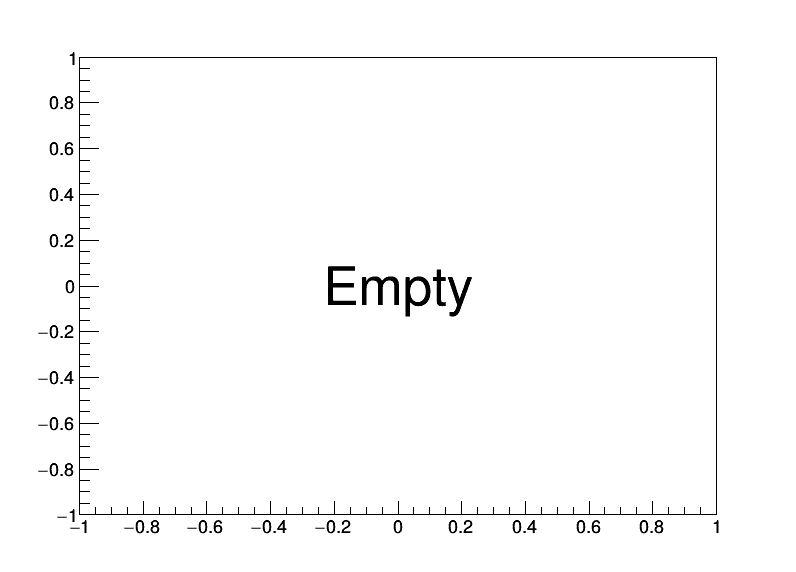

In [43]:
# plot only for "good" even chips
canv.cd(); 
cuts = basecuts + "&& rechit_energy > 1 && deltaR < 2 && rechit_skiroc%2 == 0"
tree.Draw("deltaY : deltaX ",cuts,"colz");
canv.Draw()

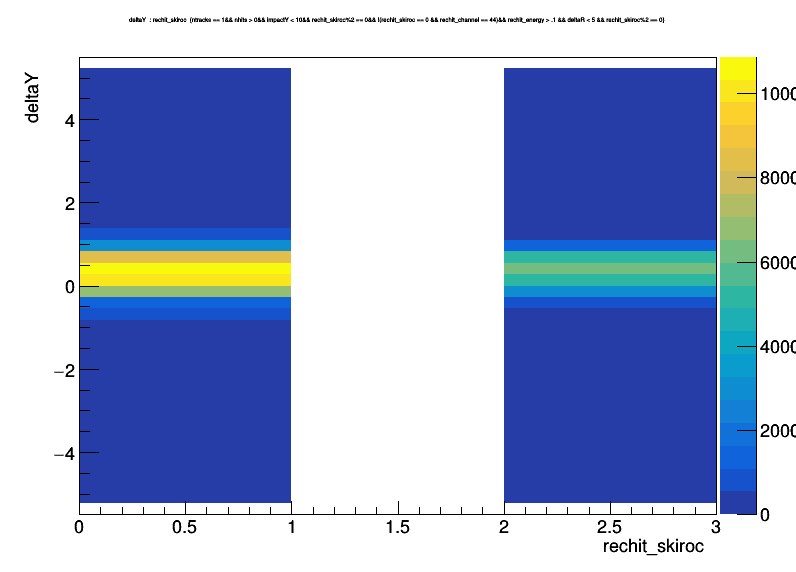

In [16]:
# plot only for "good" even chips
canv.cd(); 
cuts = basecuts + "&& rechit_energy > .1 && deltaR < 5 && rechit_skiroc%2 == 0"
tree.Draw("deltaY  : rechit_skiroc ",cuts,"colz");
canv.Draw()

Look at deltaX / deltaY and obtain mean offset (and fit gaussian)

 FCN=906.337 FROM MIGRAD    STATUS=CONVERGED      62 CALLS          63 TOTAL
                     EDM=1.1419e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.35519e+03   8.26029e+00   9.76735e-02  -2.41285e-05
   2  Mean         3.31796e-01   1.81147e-03   2.66418e-05  -2.46717e-01
   3  Sigma        3.68092e-01   1.34511e-03   1.41765e-05  -6.28301e-02


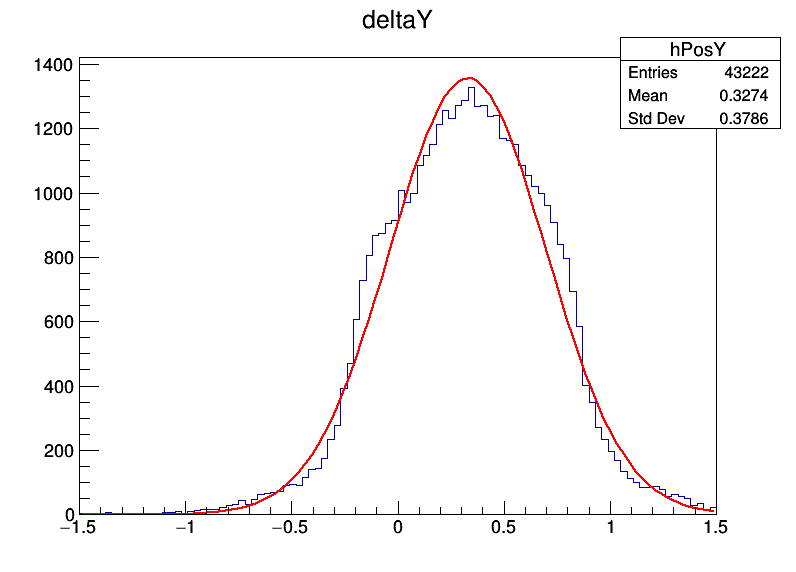

In [17]:
# require > 1 MIP to clean signal
cuts = basecuts + "&& rechit_energy > 1"

hPosY = rt.TH1F("hPosY","deltaY", 100,-1.5,1.5);
tree.Draw("deltaY >> hPosY ",cuts,"");
hPosY.Fit("gaus");

canv.Draw()

In [18]:
func = hPosY.GetFunction("gaus")

In [19]:
offset = func.GetParameter(1)

The deltaY distribution looks nice but is shifted by 0.37 / 0.33 cm (mean/fit)
- redefine impactY with the shift

In [20]:
tree.SetAlias("impactY","impact_y -14 - %s" %offset);

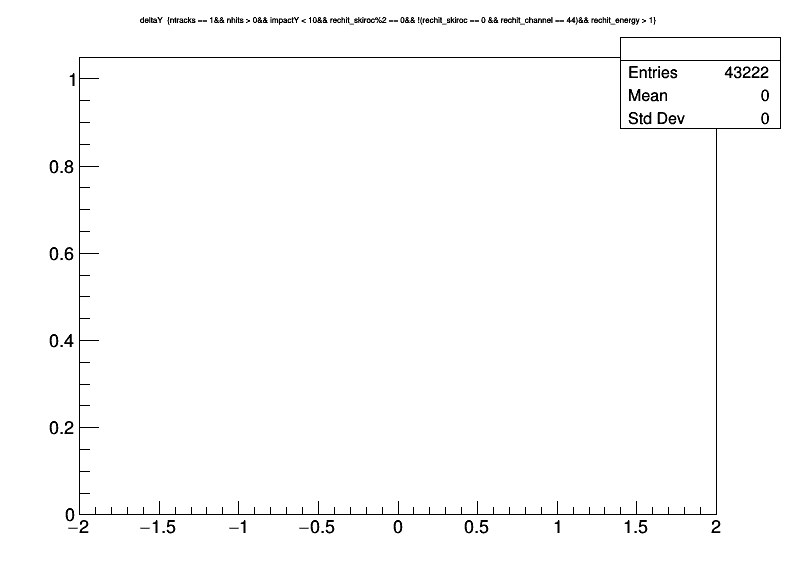

In [21]:
tree.Draw("deltaY >> (100,-2,2)",cuts,"");
canv.Draw()

 FCN=3768 FROM MIGRAD    STATUS=CONVERGED      70 CALLS          71 TOTAL
                     EDM=2.9927e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.97648e+03   1.51049e+01   2.99145e-01  -8.66298e-06
   2  Mean         3.01640e-01   2.44488e-03   7.19011e-05  -2.69945e-01
   3  Sigma        4.74956e-01   2.72359e-03   3.23533e-05  -3.89142e-01


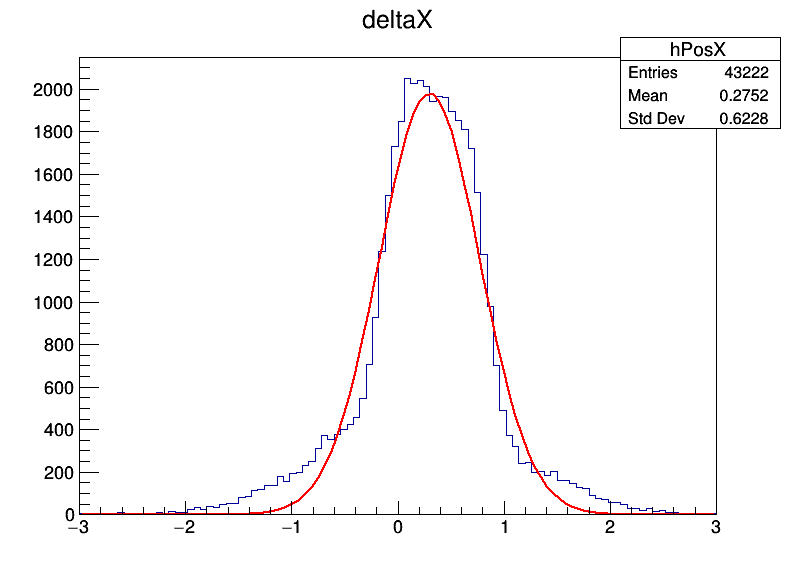

In [22]:
# require > 1 MIP to clean signal
cuts = basecuts + "&& rechit_energy > 1"

hPosX = rt.TH1F("hPosX","deltaX", 100,-3,3);
tree.Draw("deltaX >> hPosX ",cuts,"");
hPosX.Fit("gaus");

canv.Draw()

The deltaX distribution looks less nice / asymmetric and is also shifted by 0.2 / 0.21 cm (mean/fit)
- redefine impactY with the shift (guess of peak is ~0.3)

In [23]:
func = hPosX.GetFunction("gaus")
offset = func.GetParameter(1)

In [24]:
tree.SetAlias("impactX","impact_x -8.5 - %s" %offset);

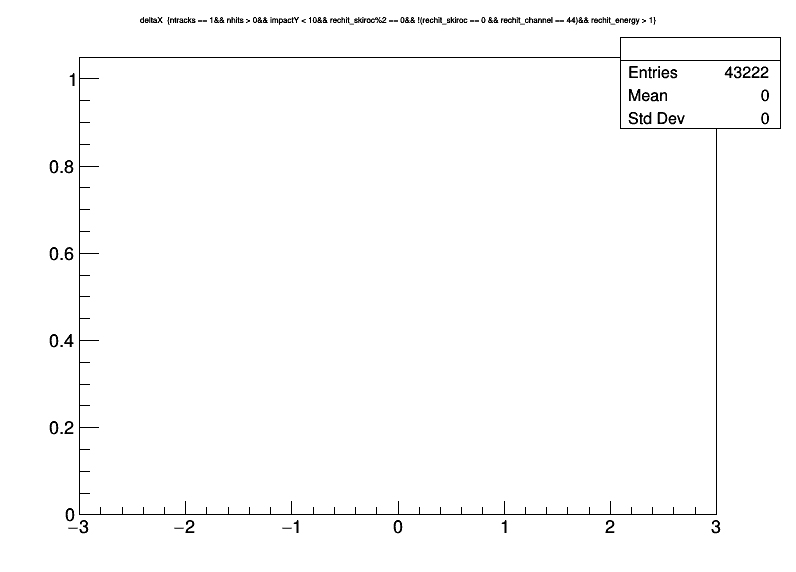

In [25]:
tree.Draw("deltaX >> (100,-3,3)",cuts,"");
canv.Draw()

### Control plots for alignment

In [26]:
## create canvas with 2 pads
canv_split = rt.TCanvas("canv_split","Split",1200,600);
canv_split.Divide(2);

#### DeltaX/deltaY vs the global channel id

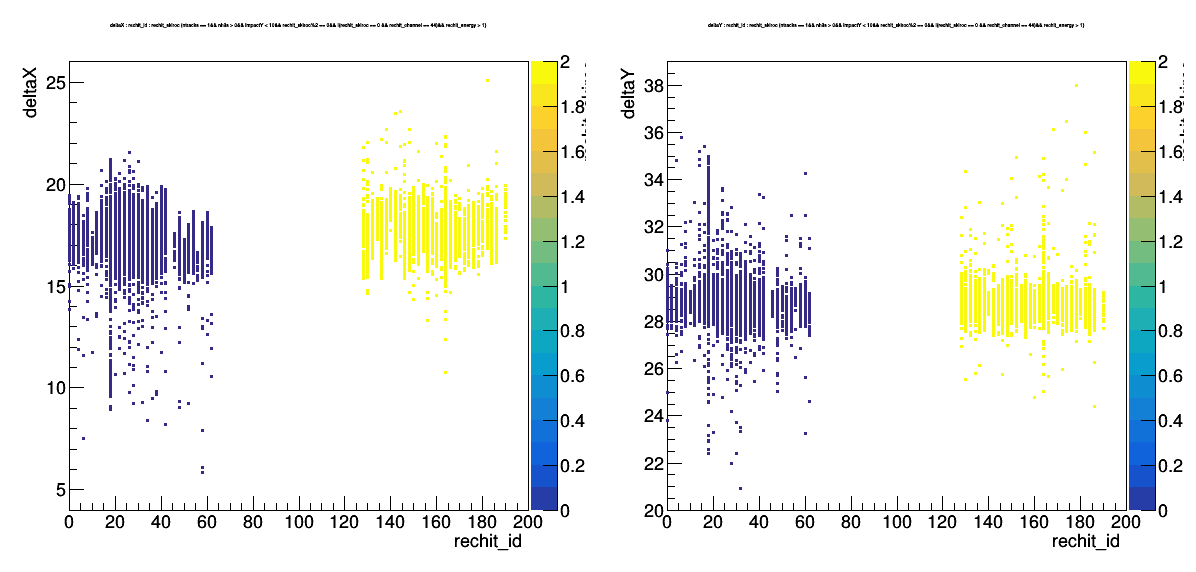

In [27]:
# require > 1 MIP to clean signal
cuts = basecuts + "&& rechit_energy > 1"

canv_split.cd(1)
tree.Draw("deltaX : rechit_id : rechit_skiroc",cuts,"pcolz");
canv_split.cd(2)
tree.Draw("deltaY : rechit_id : rechit_skiroc",cuts,"pcolz");

canv_split.Draw()

Chips 0 and 2 are flat, while chips 1 and 3 show symmetric misalignment patterns

#### Deltas vs run = scan position

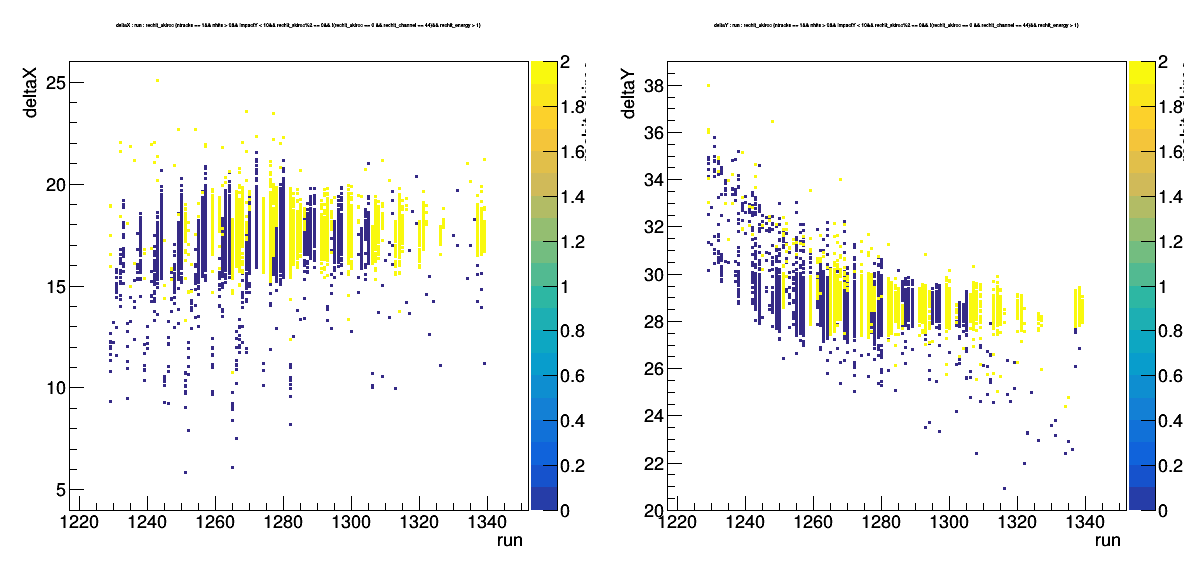

In [28]:
canv_split.cd(1)
tree.Draw("deltaX : run : rechit_skiroc",cuts,"pcolz");
canv_split.cd(2)
tree.Draw("deltaY : run : rechit_skiroc",cuts,"pcolz");

canv_split.Draw()

Deltas of chips 0 and 2 are stable wrt the run/stage position, while for chips 1 and 3 there is a trend pointing to misalignment of the rechit positions.

#### DeltaR vs channel ID and run number

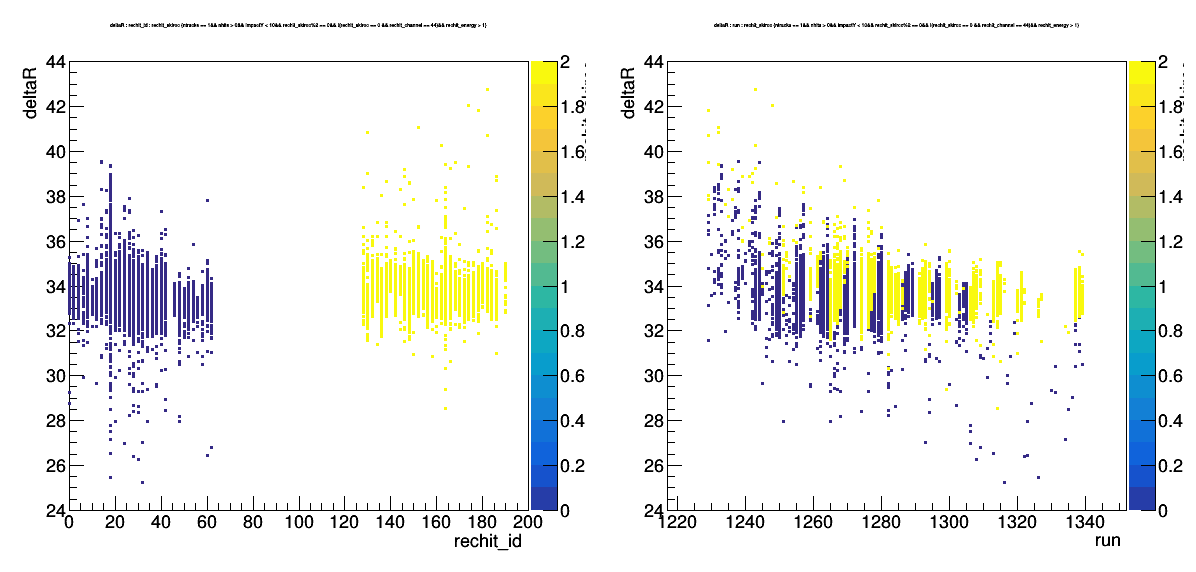

In [29]:
canv_split.cd(1); tree.Draw("deltaR : rechit_id : rechit_skiroc",cuts,"pcolz");
canv_split.cd(2); tree.Draw("deltaR : run : rechit_skiroc",cuts,"pcolz");
canv_split.Draw()

Again, for chips 0 and 2 the deltaR is low and flat, whereas for chips 1 and 3 there are symmetric offests

### Check X and Y impact alignment

Use only the "good" even channels to do the alignment

Warning in <TROOT::Append>: Replacing existing TH1: hPosX (Potential memory leak).
Warning in <Fit>: Fit data is empty 
Warning in <TROOT::Append>: Replacing existing TH1: hPosY (Potential memory leak).
Warning in <Fit>: Fit data is empty 


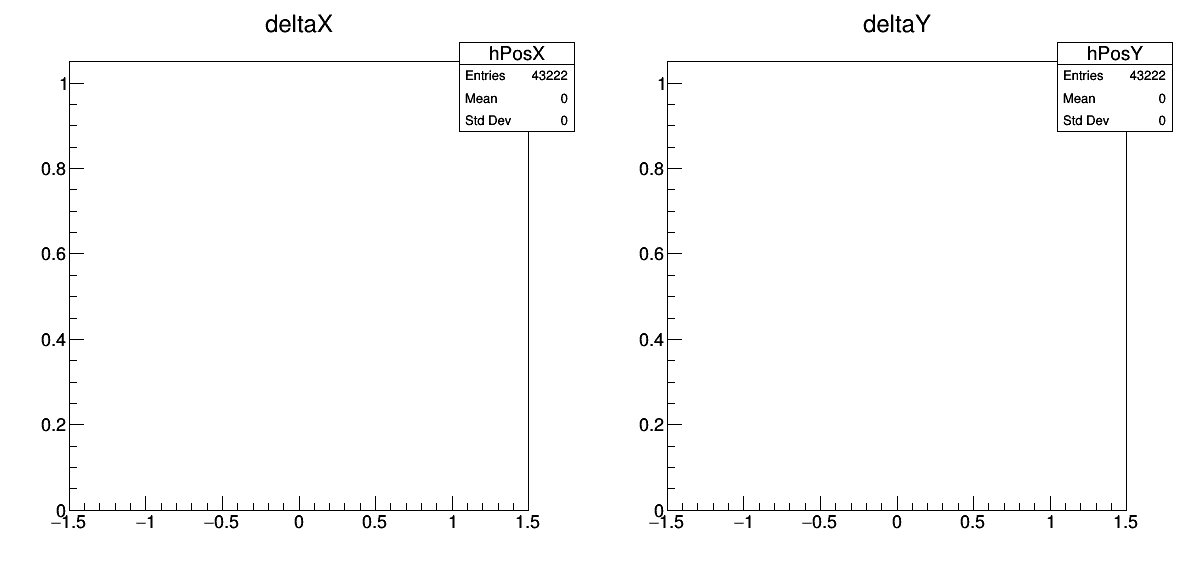

In [30]:
cuts = basecuts + "&& rechit_energy > 1 && rechit_skiroc%2 == 0"

## deltaX
canv_split.cd(1); 
hPosX = rt.TH1F("hPosX","deltaX", 100,-1.5,1.5); tree.Draw("deltaX >> hPosX ",cuts,"");
hPosX.Fit("gaus");

## deltaY
canv_split.cd(2); 
hPosY = rt.TH1F("hPosY","deltaY", 100,-1.5,1.5); tree.Draw("deltaY >> hPosY ",cuts,"");
hPosY.Fit("gaus");

canv_split.Draw()

#### Check deltaR

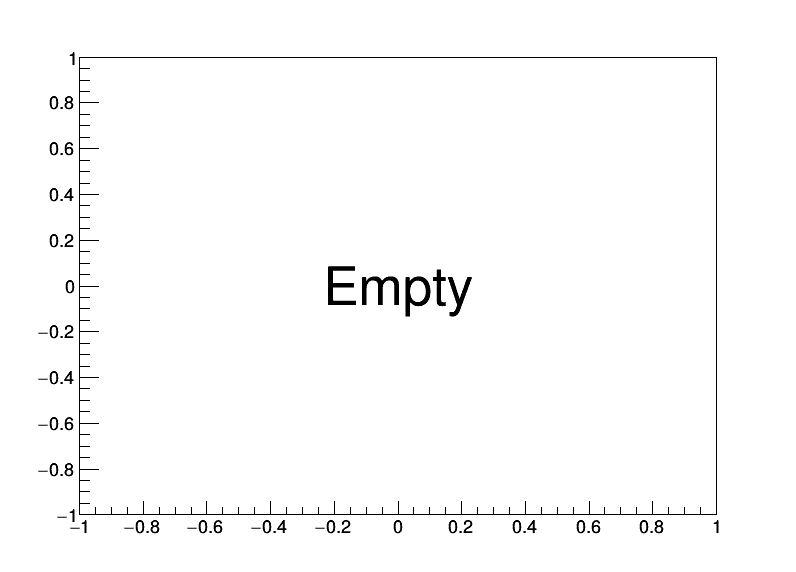

In [31]:
canv.cd() # return to single pad canvas
# plot only for "good" even chips
cuts = basecuts + "&& rechit_energy > 1 && deltaR < 4 && rechit_skiroc%2 == 0"; tree.Draw("deltaR ",cuts,"");
# overlay plot for even chips
cuts = basecuts + "&& rechit_energy > 1 && deltaR < 4 && rechit_skiroc%2 == 1"; tree.Draw("deltaR ",cuts,"p same");
canv.Draw()

`deltaR` still not centred at 0

#### Overall plot of deltaX/Y

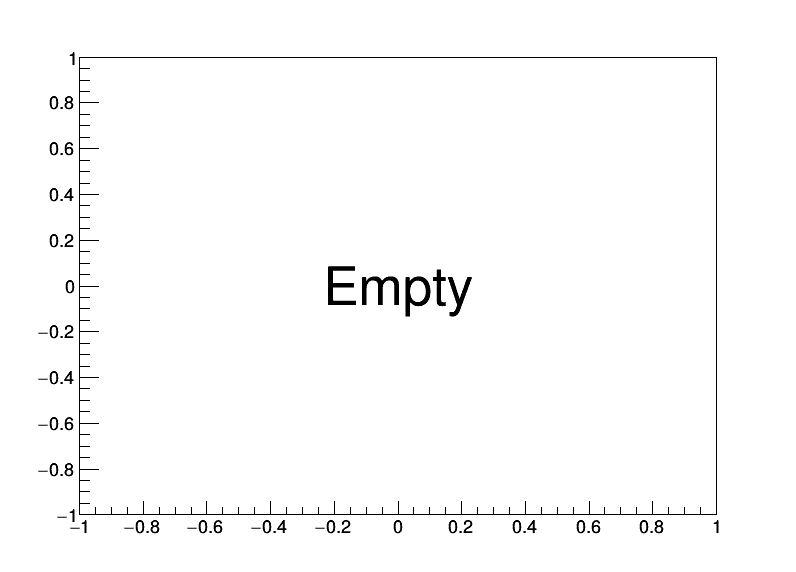

In [32]:
# plot only for "good" even chips
canv.cd(); 
cuts = basecuts + "&& rechit_energy > 1 && deltaR < 2 && rechit_skiroc%2 == 0"
tree.Draw("deltaY : deltaX ",cuts,"colz");
canv.Draw()

## Plots of energy

In [33]:
# return to basic cuts
cuts = basecuts

#### Plot rechit energy vs deltaR for each chip individually

In [34]:
# Divide new canvas into four pads and increase size
canv_split4 = rt.TCanvas("canv_split4","Split",2000,1200);
canv_split4.Divide(2,2);

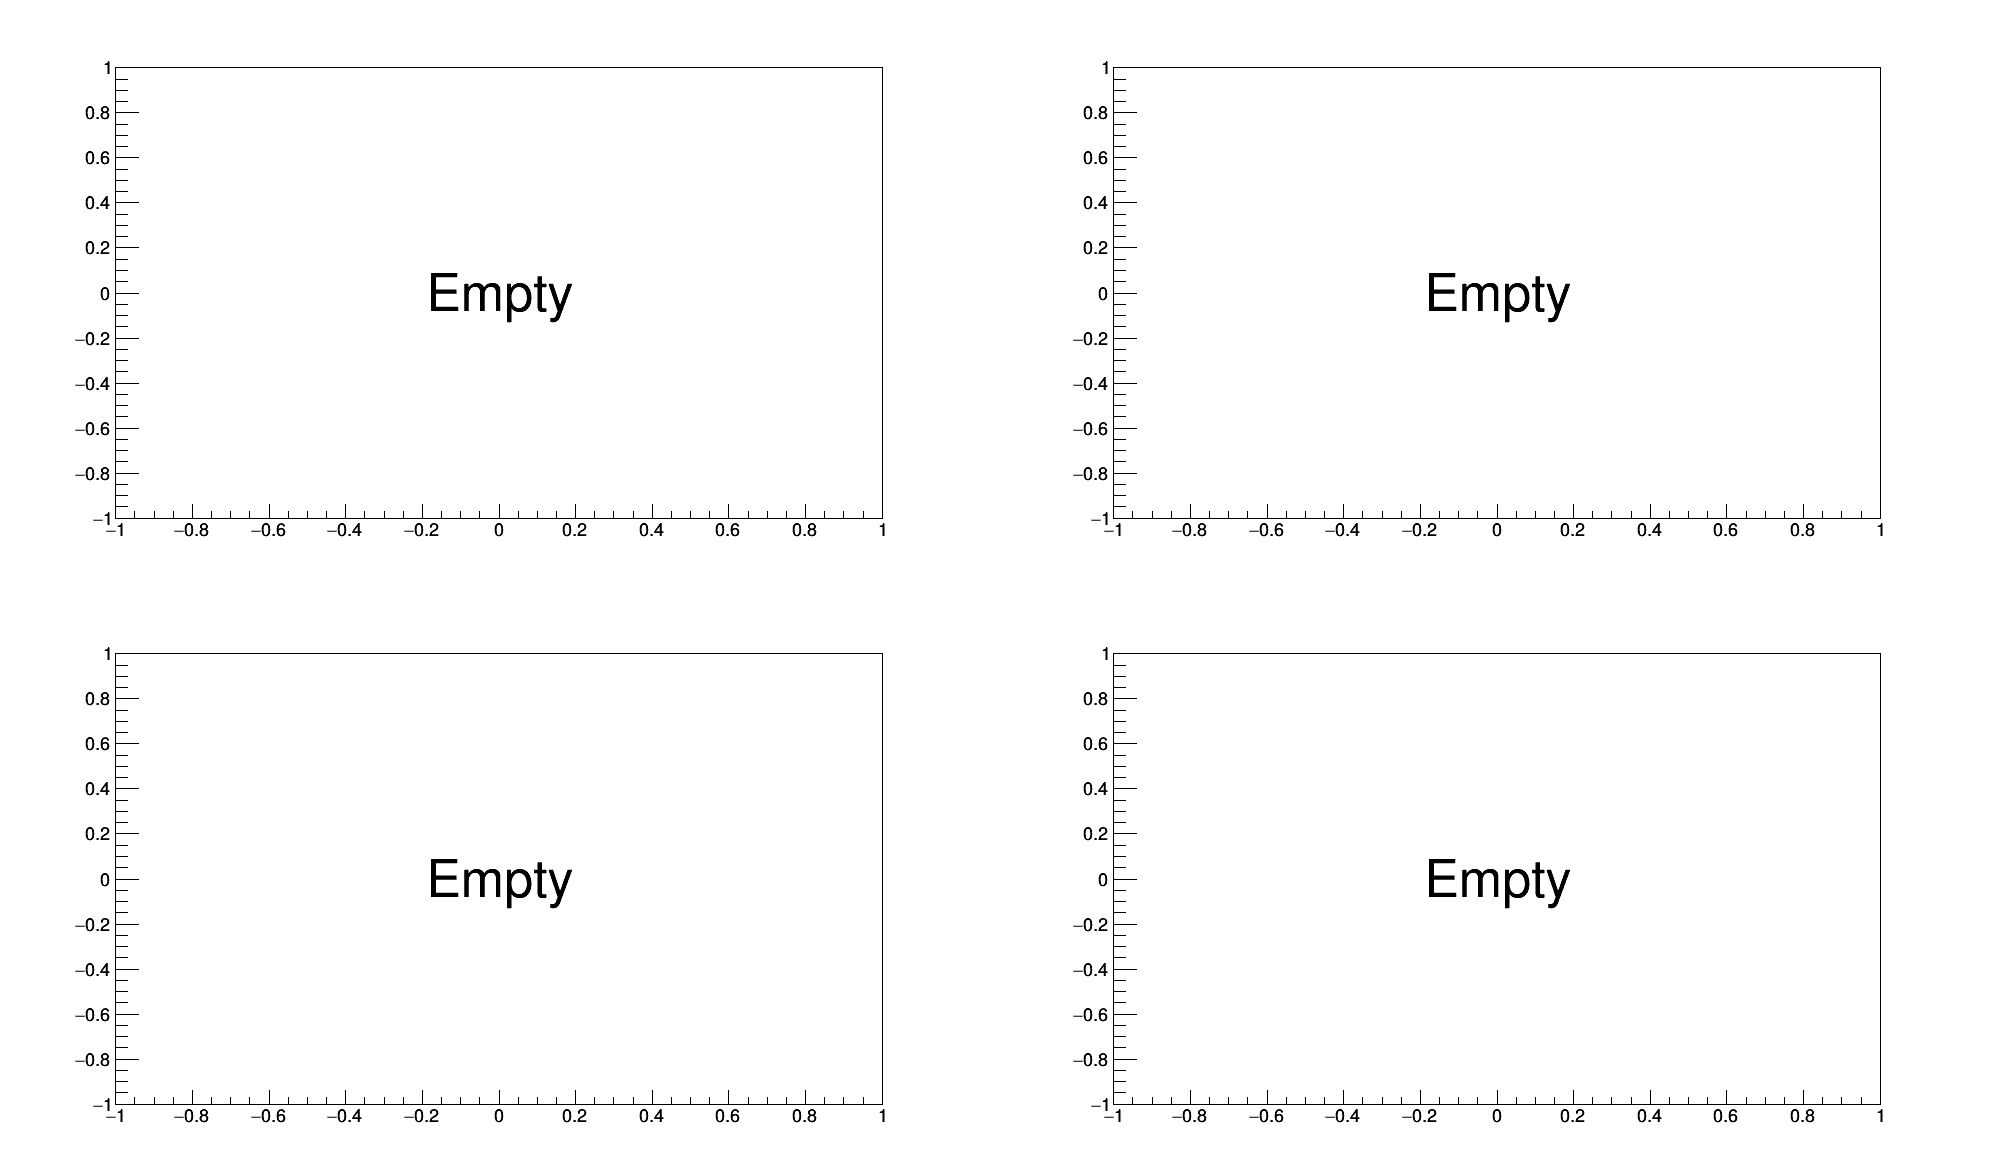

In [35]:
for chip in range(4):
    canv_split4.cd(chip+1);
 
    cuts = basecuts + " && deltaR < 10 && rechit_skiroc == %i" %chip;
    tree.Draw("rechit_energy : deltaR : rechit_channel",cuts,"pcolz");
    
canv_split4.Draw()

#### Plot rechit energy (HG) for different deltaR cuts

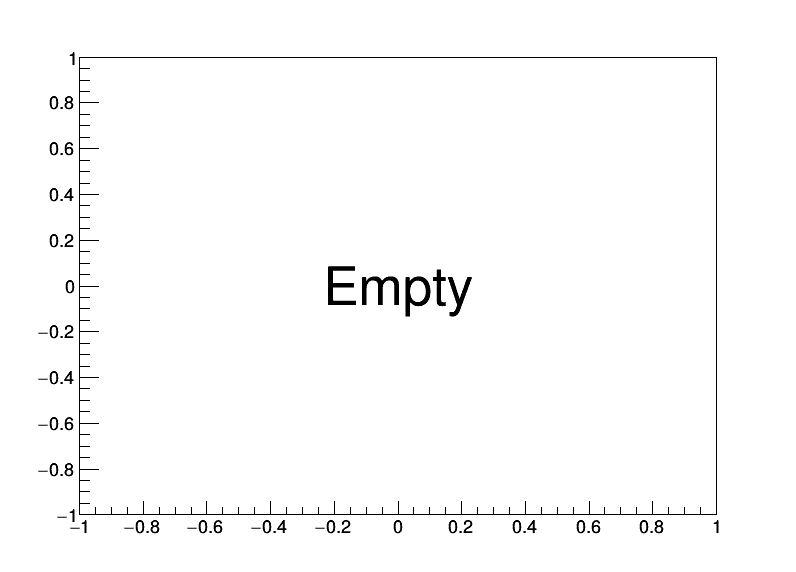

In [36]:
canv.cd()
cuts = basecuts + " && rechit_skiroc%2 == 0 && rechit_energy < 4 && deltaR < 10";
tree.Draw("rechit_energy",cuts,"");

cuts += " && deltaR < 2";
tree.Draw("rechit_energy",cuts,"p same");

canv.Draw()

Error in <TH1F::DrawNormalized>: Sum of weights is null. Cannot normalize histogram: h_chip 0_MIP
Error in <TH1F::DrawNormalized>: Sum of weights is null. Cannot normalize histogram: h_chip 1_MIP
Error in <TH1F::DrawNormalized>: Sum of weights is null. Cannot normalize histogram: h_chip 2_MIP
Error in <TH1F::DrawNormalized>: Sum of weights is null. Cannot normalize histogram: h_chip 3_MIP


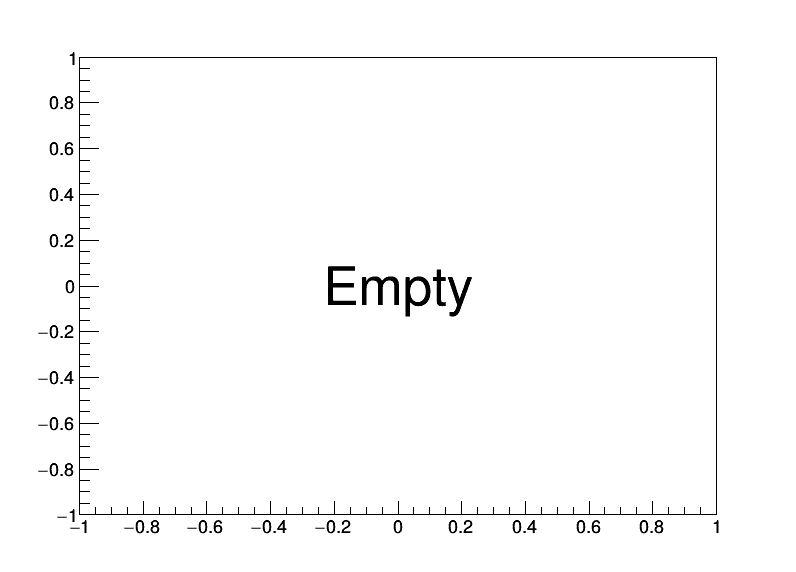

In [37]:
popt = "hist PLC PMC"
canv.cd()
for chip in range(0,4,1):
    cuts = basecuts + " && rechit_energy < 4 && deltaR < 2";
    cuts += "&& rechit_skiroc == %i" %chip
    
    hname = "h_chip %i" % chip
    tree.Draw("rechit_energy >> " + hname +"_MIP(100,0.5,3)", cuts, "goff");
    
    hist = rt.gDirectory.Get(hname+"_MIP")
    hist.DrawNormalized(popt)

    
    popt += "same"
canv.Draw()

Error in <THistPainter::PaintInit>: log scale requested with a negative argument (-1.000000)


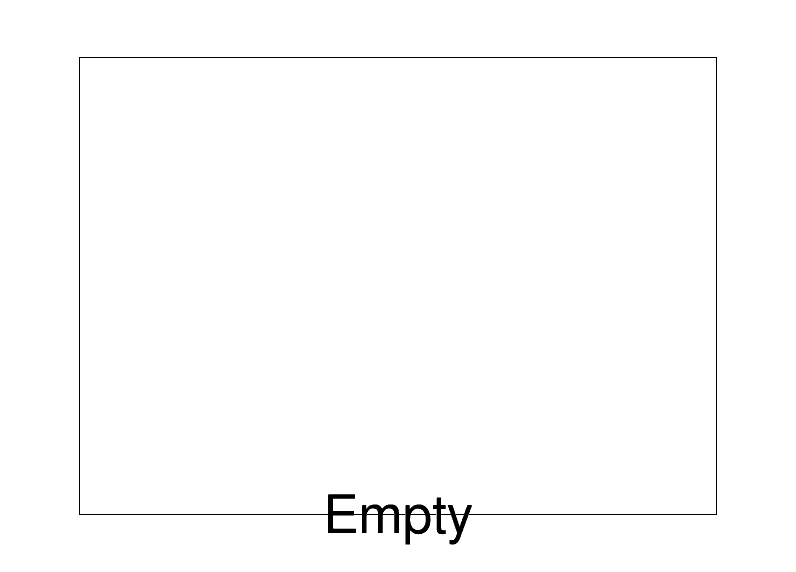

In [38]:
canv.cd().SetLogy()
canv.Draw()

In [39]:
canv.cd().SetLogy(0)

## MIP / MPV

Plot rechit energy vs channel id

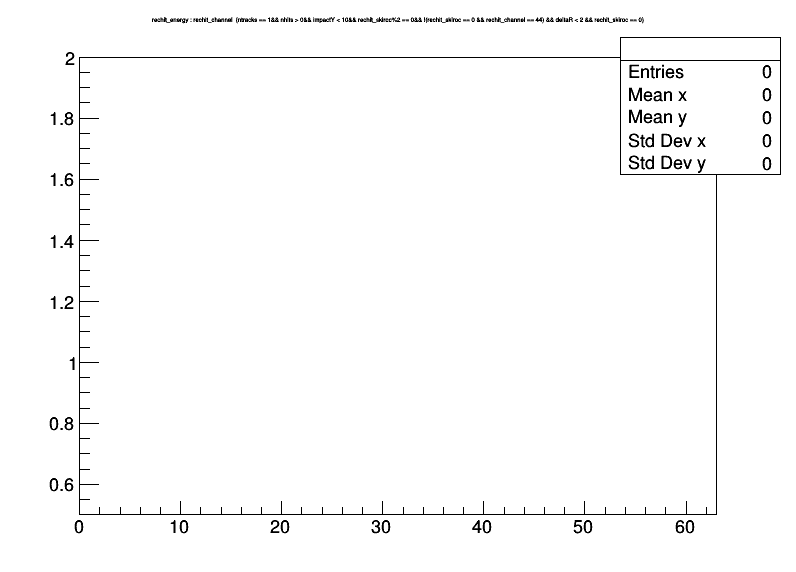

In [40]:
cuts = basecuts + " && deltaR < 2 && rechit_skiroc == 0";
tree.Draw("rechit_energy : rechit_channel >> (64,0,63,100,0.5,2)", cuts,"colz");
canv.Draw()

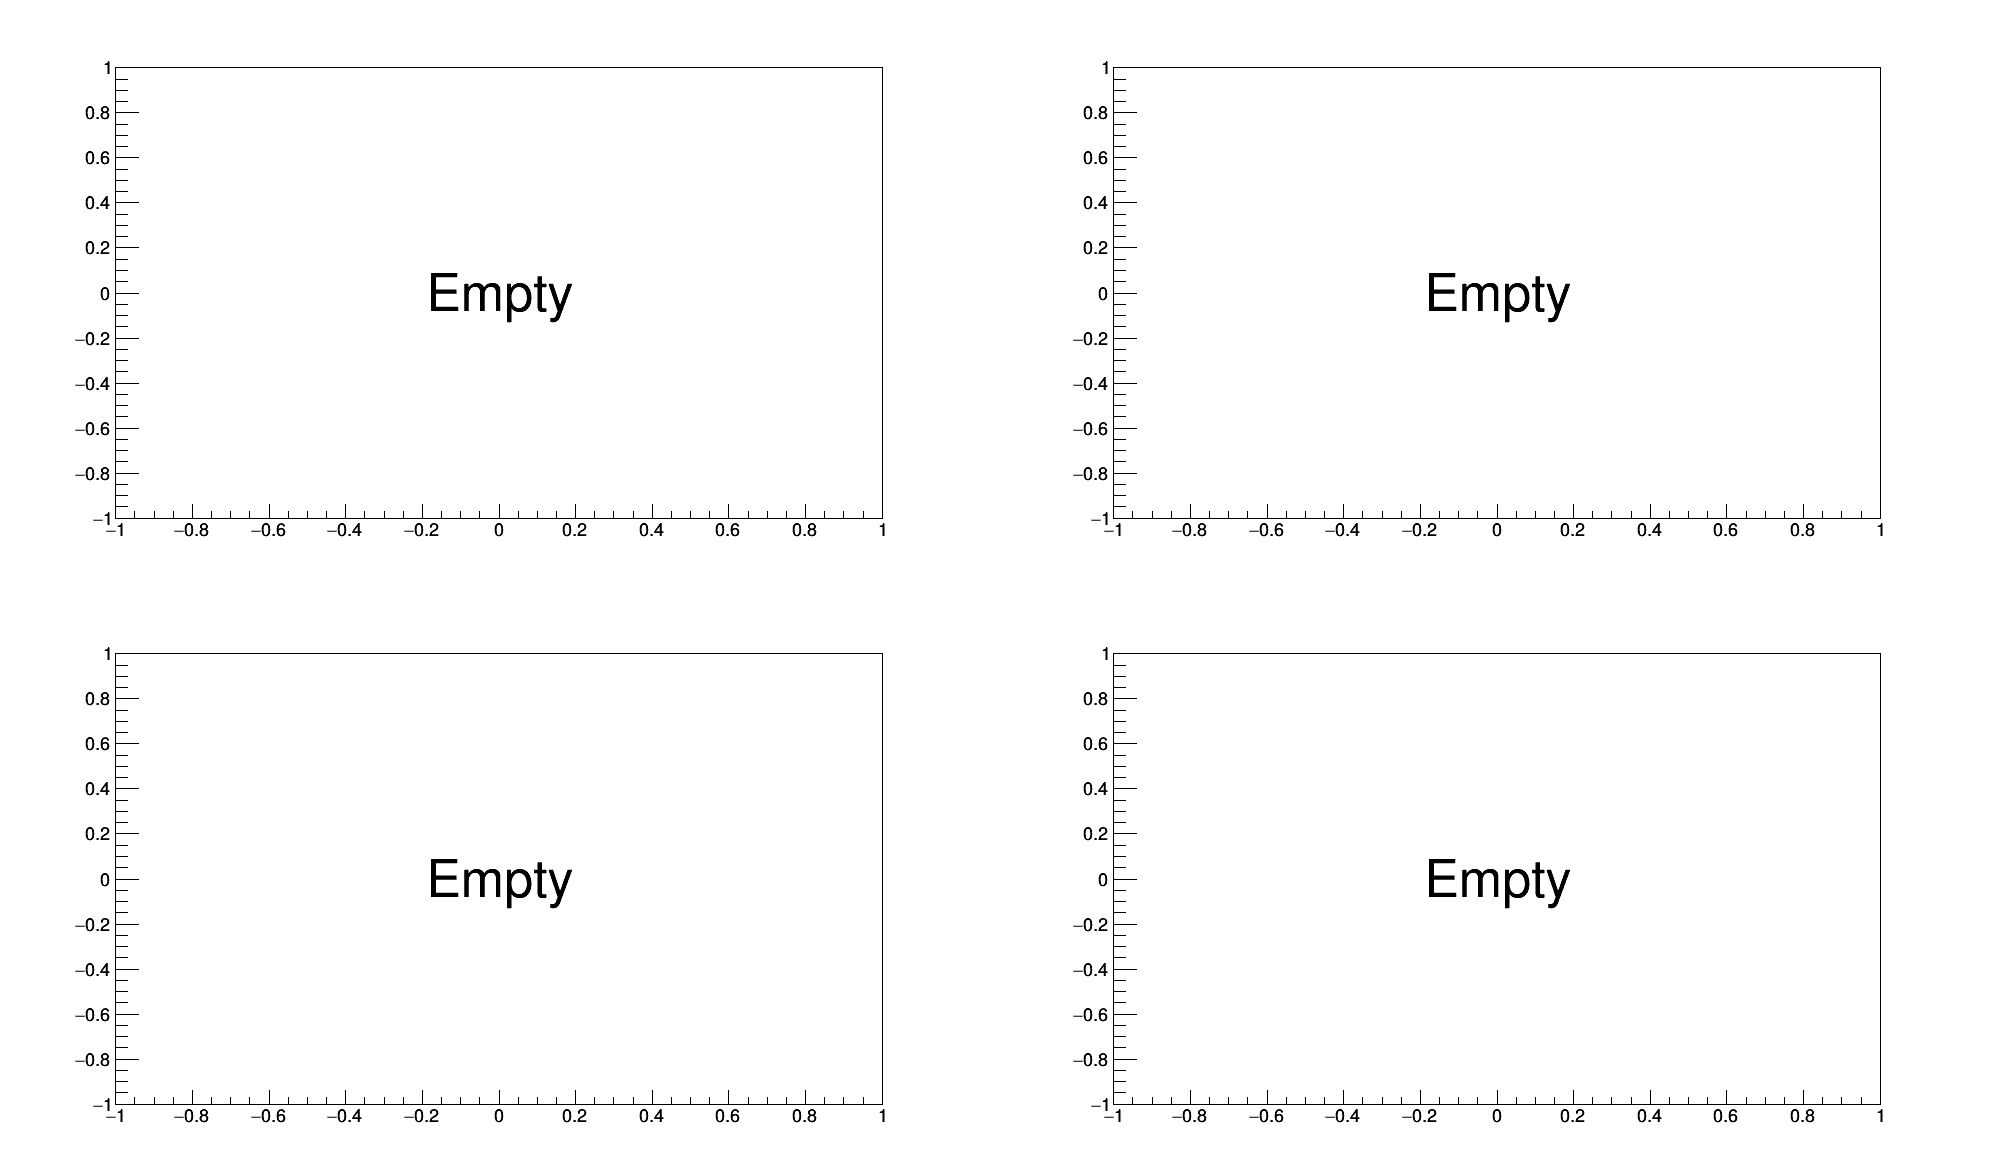

In [41]:
for chip in range(4):
    canv_split4.cd(chip+1);
 
    cuts = basecuts + " && rechit_energy > 1 && deltaR < 10 && rechit_skiroc == %i" %chip;
    tree.Draw("deltaX : run : rechit_channel",cuts,"pcolz");
    
canv_split4.Draw()

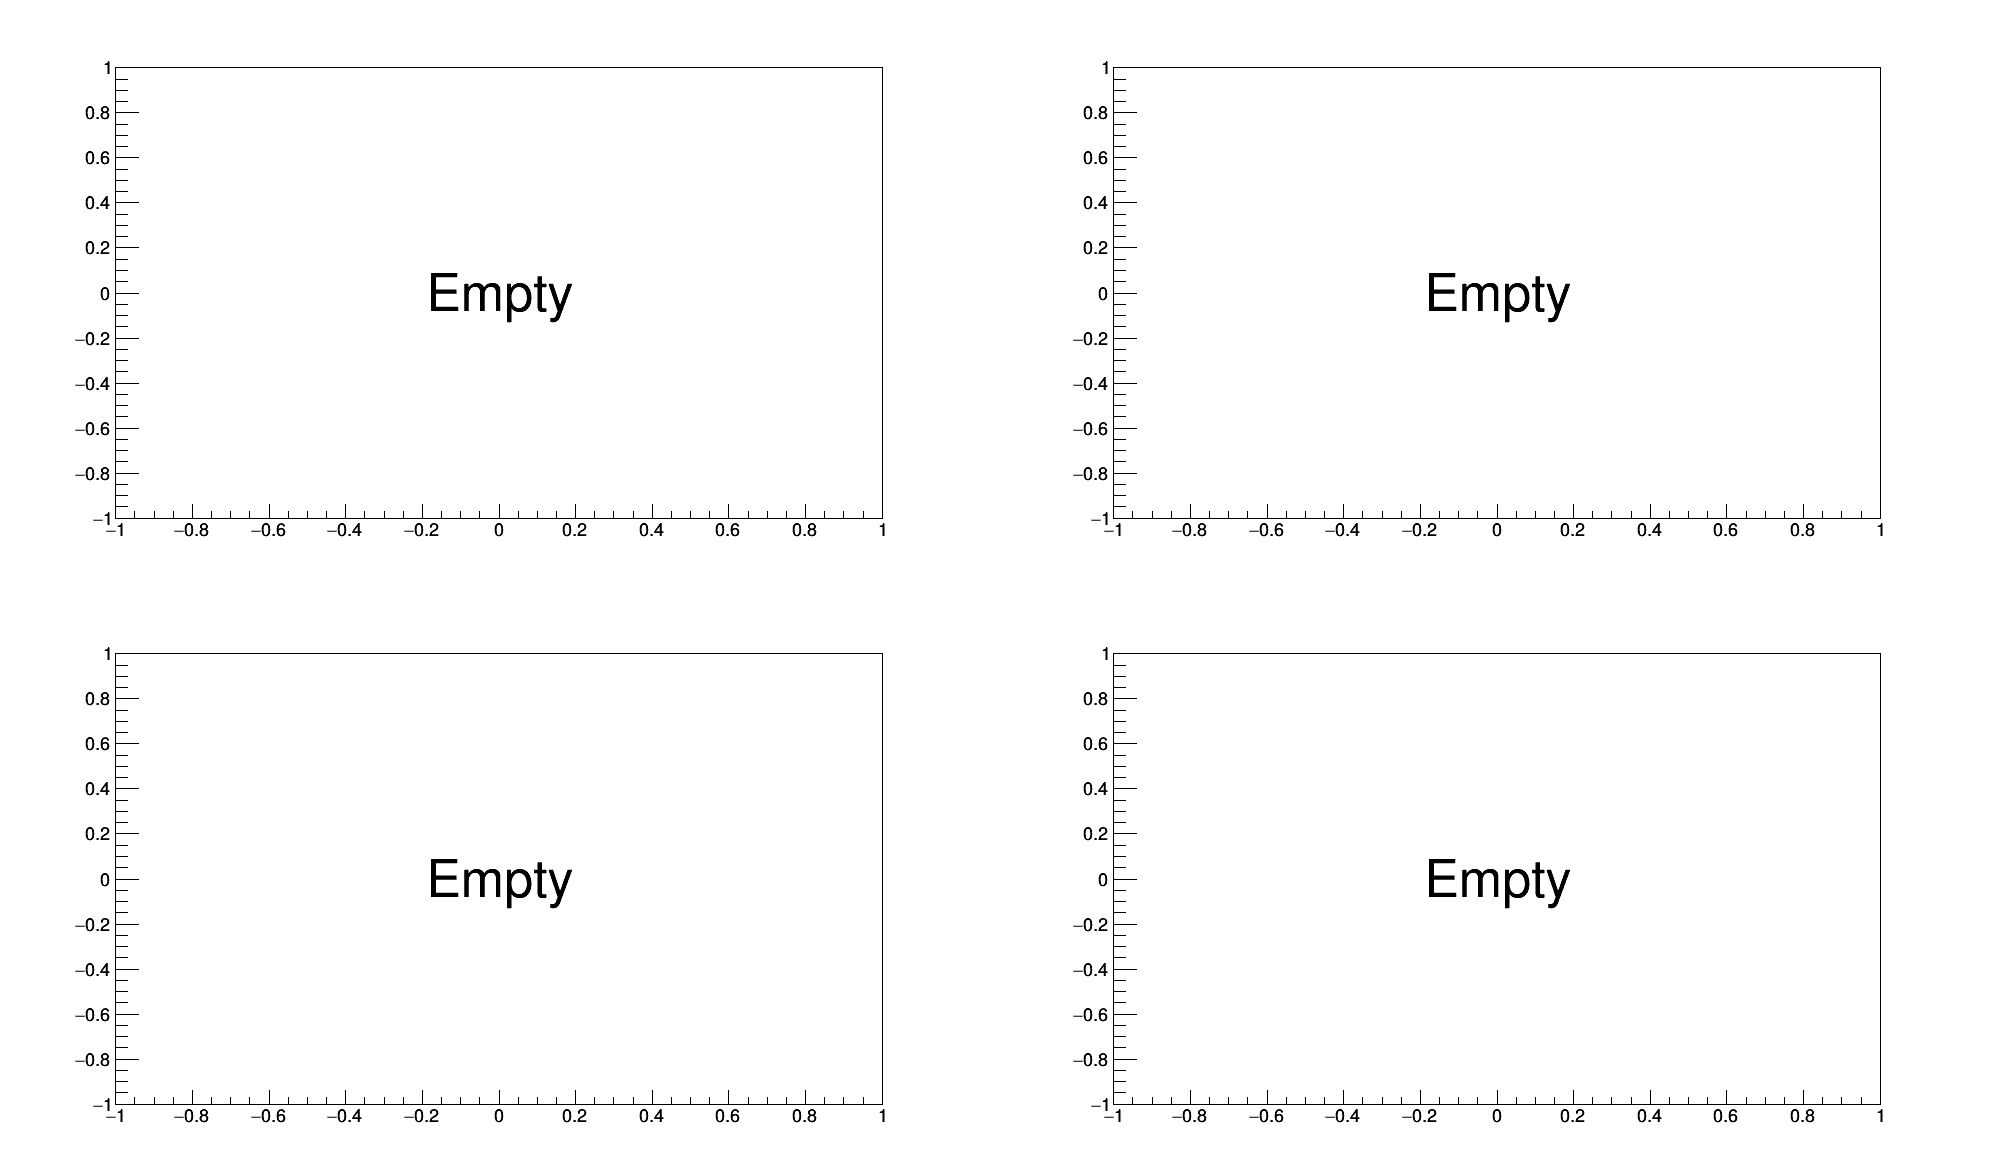

In [42]:
for chip in range(4):
    canv_split4.cd(chip+1);
 
    cuts = basecuts + " && rechit_energy > 1 && deltaR < 10 && rechit_skiroc == %i" %chip;
    tree.Draw("deltaY : run : rechit_channel",cuts,"pcolz");
    
canv_split4.Draw()